In [1]:
import pandas as pd
import numpy as np

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

precip = pd.read_csv('precip.csv', parse_dates=['fecha'])

pd.set_option('display.max_colwidth', 50)

In [2]:
precip = precip[(precip['fecha'] >= '1953-03-01')]
precip = precip[precip.zona == 'norte']
precip = precip.set_index('fecha')
precip = precip.sort_index()
precip.info()
precip

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26329 entries, 1953-03-01 to 2025-03-31
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   zona                26329 non-null  object 
 1   PRECIP(mm)          26329 non-null  float64
 2   EVAP(mm)            26329 non-null  float64
 3   TMAX(°C)            26329 non-null  float64
 4   TMIN(°C)            26329 non-null  float64
 5   PRECIP(mm)_was_nan  26329 non-null  int64  
 6   EVAP(mm)_was_nan    26329 non-null  int64  
 7   TMAX(°C)_was_nan    26329 non-null  int64  
 8   TMIN(°C)_was_nan    26329 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 2.0+ MB


,zona,PRECIP(mm),EVAP(mm),TMAX(°C),TMIN(°C),PRECIP(mm)_was_nan,EVAP(mm)_was_nan,TMAX(°C)_was_nan,TMIN(°C)_was_nan
fecha,,,,,,,,,
1953-03-01,norte,1.181047,3.493528,29.173546,16.144749,1,1,1,1
1953-03-02,norte,1.181047,3.493528,29.173546,16.144749,1,1,1,1
1953-03-03,norte,1.181047,3.493528,29.173546,16.144749,1,1,1,1
1953-03-04,norte,1.181047,3.493528,29.173546,16.144749,1,1,1,1
1953-03-05,norte,1.181047,3.493528,29.173546,16.144749,1,1,1,1
...,...,...,...,...,...,...,...,...,...
2025-03-27,norte,1.181047,3.493528,29.173546,16.144749,1,1,1,1
2025-03-28,norte,1.181047,3.493528,29.173546,16.144749,1,1,1,1
2025-03-29,norte,1.181047,3.493528,29.173546,16.144749,1,1,1,1


In [3]:
precip = precip[['PRECIP(mm)']]

In [4]:
precip.describe()

,PRECIP(mm)
count,26329.000000
mean,3.849701
std,11.478175
min,0.000000
25%,0.000000
50%,0.000000
75%,2.711963
max,312.300000


<AxesSubplot: xlabel='fecha'>

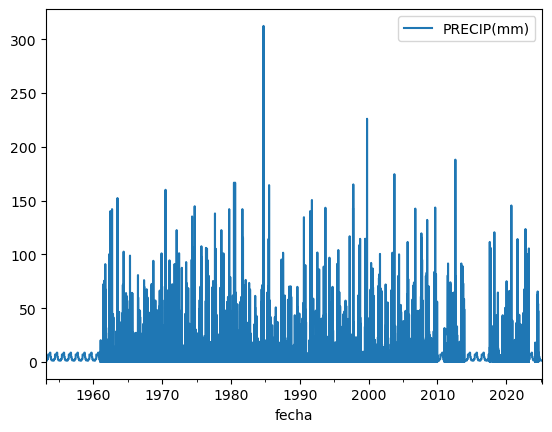

In [5]:
import matplotlib.pyplot as plt
precip.plot()

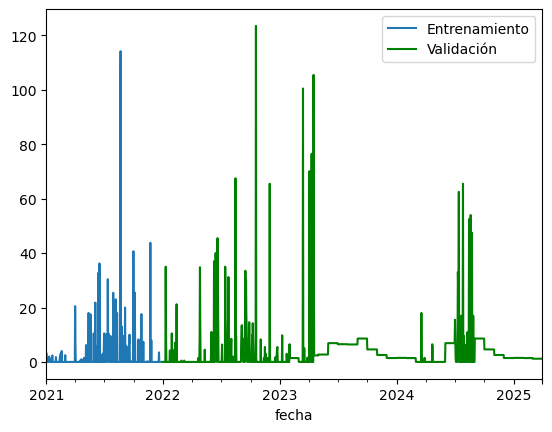

In [6]:
data_train = precip.loc['1953-03-01':'2021-12-31']
data_test = precip.loc['2022-01-01':]

ax = data_train.loc['2021-01-01':].plot( label='Entrenamiento')
ax = data_test.plot(ax=ax, color='green', label='Validación')
_= ax.legend(labels=[ 'Entrenamiento', 'Validación'])

In [7]:
from sklearn.preprocessing import PowerTransformer

#pt = PowerTransformer(method = 'yeo-johnson')
#data_train = pt.fit_transform(data_train)

data_train = np.log1p(data_train)
data_train = data_train.values

In [8]:
import numpy as np

time_step = 90
X_train = []
y_train = []
m = len(data_train)

for i in range(time_step, m):
    
    X_train.append(data_train[i-time_step:i, 0])
    y_train.append(data_train[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

y_test = data_test.values[time_step:]

In [9]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth habilitado.")
    except RuntimeError as e:
        print(e)

Memory growth habilitado.


In [10]:
#raise StopExecution("Detenido manualmente")

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(units=75, input_shape=(X_train.shape[1], 1), return_sequences=True), 
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=32, activation='relu'), 
    Dropout(0.2),
    Dense(units=1, activation='linear')
])

In [12]:
model.compile(optimizer='adam', 
              loss='mae', 
              metrics='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 75)            23100     
                                                                 
 dropout (Dropout)           (None, 90, 75)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                25200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3

# JUSTIFICACION

__La precipitación es un fenómeno que depende mucho de lo que ocurrió en días anteriores: si ha llovido constantemente o si ha habido sequías, eso influye en el valor del siguiente día. Eso hace que las LSTM sean una buena elección para que la NN pueda recordar y aprender de secuencias pasadas. Ya que las LSTM entienden cómo una serie de valores cambia con el tiempo, nos ayuda capturar los patrones temporales complejos de las precipitaciones.__

__Las capas Dropout nos ayudan a que el modelo no se sobreajuste al dejar porciones de datos fuera del entrenamiento, siendo diferentes esas porciones cada vez que pasan por ellas.__

__La capacidad del optimizador adam para adaptar su ritmo de aprendizaje nos es de utilidad para el modelo que trabajará con muchos datos o con estructuras complejas como las LSTM, ya que ayuda al modelo a aprender de manera más estable y eficiente sin que tengamos que ajustar tanto los parámetros a mano.__

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(
    min_delta = 0.001,
    patience = 40, 
    restore_best_weights = True
)

model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    x = X_train,
    y = y_train,
    validation_split=0.2,
    epochs = 150,
    batch_size = 64,
    callbacks = [early_stopping, model_checkpoint],
)

Epoch 1/150
314/314 [==============================] - 7s 15ms/step - loss: 0.5670 - mae: 0.5670 - val_loss: 0.4720 - val_mae: 0.4720
Epoch 2/150
314/314 [==============================] - 4s 13ms/step - loss: 0.5407 - mae: 0.5407 - val_loss: 0.4402 - val_mae: 0.4402
Epoch 3/150
314/314 [==============================] - 4s 13ms/step - loss: 0.5289 - mae: 0.5289 - val_loss: 0.4120 - val_mae: 0.4120
Epoch 4/150
314/314 [==============================] - 4s 13ms/step - loss: 0.5182 - mae: 0.5182 - val_loss: 0.4117 - val_mae: 0.4117
Epoch 5/150
314/314 [==============================] - 4s 13ms/step - loss: 0.5013 - mae: 0.5013 - val_loss: 0.4076 - val_mae: 0.4076
Epoch 6/150
314/314 [==============================] - 4s 13ms/step - loss: 0.5009 - mae: 0.5009 - val_loss: 0.4087 - val_mae: 0.4087
Epoch 7/150
314/314 [==============================] - 4s 12ms/step - loss: 0.4967 - mae: 0.4967 - val_loss: 0.4115 - val_mae: 0.4115
Epoch 8/150
314/314 [==============================] - 4s 13ms

In [14]:
x_test= data_test.values
#x_test= pt.transform(x_test)
x_test = np.log1p(x_test)

X_test = []
for i in range (time_step, len(x_test)):
  X_test.append(x_test[i-time_step:i,0])

X_test= np.array(X_test)
X_test= np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

prediccion= model.predict(X_test)
#prediccion= pt.inverse_transform(prediccion)
prediccion = np.expm1(prediccion)

prediccion = pd.Series(prediccion.flatten(), index=data_test.index[time_step:])

35/35 [==============================] - 1s 4ms/step


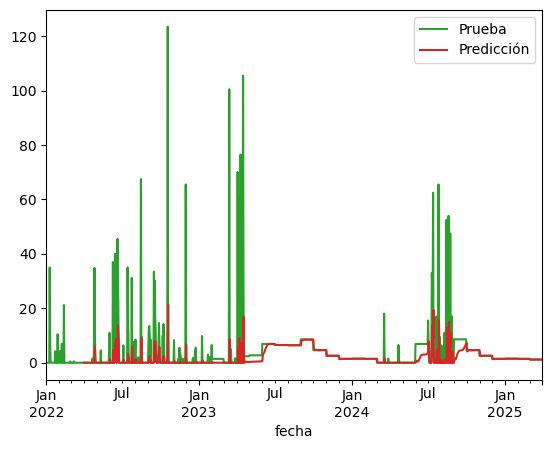

In [15]:
ax=data_test.plot(color='C2', label='Validación')
ax=prediccion.plot(ax=ax,color='C3', label='Predicción')
_=ax.legend(labels=['Prueba', 'Predicción'])